In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score


### Configuration and Constants

In [2]:
DATA_DIR = '../data/'
FEATURES_FILE = 'features_to_include.csv'
ALL_DATA_FILE = 'all_data.csv'

# Define bins and labels for age categorization
AGE_BINS = [17, 25, 45, 67]
AGE_LABELS = ['18-25', '25-45', '45-67']

# Define real distribution counts for age groups
REAL_DISTR_AGE = np.array([92793, 211801, 159292])

# Define real distribution counts for districts
REAL_COUNTS_DISTRICT = {
    'adres_recentste_wijk_charlois': 70525,
    'adres_recentste_wijk_delfshaven': 77250,
    'adres_recentste_wijk_feijenoord': 79440,
    'adres_recentste_wijk_ijsselmonde': 62670,
    'adres_recentste_wijk_kralingen_c': 56010,
    'adres_recentste_wijk_noord': 52795,
    'adres_recentste_wijk_other': 131855,
    'adres_recentste_wijk_prins_alexa': 97430,
    'adres_recentste_wijk_stadscentru': 42565,
}

RANDOM_STATE = 42

### Helper Functions

In [3]:
def load_features(features_path: str) -> list:
    """Load features to exclude based on the inclusion criteria."""
    features_df = pd.read_csv(features_path, delimiter=';')
    excluded = features_df[features_df['Include'] == 0]['Feature (nl)'].tolist()
    print(f"Number of features to exclude: {len(excluded)}")
    return excluded

def classify_features(df: pd.DataFrame) -> pd.DataFrame:
    """Classify features into Binary, Integer, Continuous, or Unknown."""
    summary = []
    for col in df.columns:
        col_data = df[col].dropna()
        unique_vals = set(col_data.unique())
        is_binary = unique_vals.issubset({0, 1})
        is_integer = np.all(np.equal(np.mod(col_data, 1), 0))
        
        if is_binary:
            feature_type = "Binary"
            details = f"Values: {sorted(unique_vals)}"
        elif is_integer:
            feature_type = "Integer"
            details = f"Range: {col_data.min()} to {col_data.max()}"
        elif not is_integer and col_data.dtype.kind in 'fi':  # float or integer
            feature_type = "Continuous"
            details = f"Range: {col_data.min()} to {col_data.max()}"
        else:
            feature_type = "Unknown"
            details = f"Values: {sorted(unique_vals)}"
        
        summary.append({
            'Feature': col,
            'Type': feature_type,
            'Details': details
        })
    
    return pd.DataFrame(summary)

def scale_features(df: pd.DataFrame, feature_names: list) -> pd.DataFrame:
    """Scale specified integer features using MinMaxScaler."""
    scaler = MinMaxScaler()
    df[feature_names] = scaler.fit_transform(df[feature_names])
    return df

def calculate_weight_mapping(current_counts: pd.Series, real_counts: np.ndarray) -> dict:
    """Calculate weight mapping based on real distribution."""
    current_proportions = current_counts / current_counts.sum()
    desired_proportions = real_counts / real_counts.sum()
    weight_mapping = desired_proportions / current_proportions.values
    return dict(zip(AGE_LABELS, weight_mapping))

def calculate_district_weights(X_train: pd.DataFrame, district_cols: list, real_counts: dict) -> pd.Series:
    """Calculate and normalize district weights."""
    current_counts = X_train[district_cols].sum()
    current_proportions = current_counts / current_counts.sum()
    real_counts_series = pd.Series(real_counts)
    desired_proportions = real_counts_series / real_counts_series.sum()
    weight_mapping = (desired_proportions / current_proportions).to_dict()
    
    # Assign weights based on district
    district_weights = X_train[district_cols].dot(pd.Series(weight_mapping))
    district_weights = district_weights.replace(0, 1)  # Set weight to 1 for samples with no district info
    return district_weights

def plot_top_features(feature_importance: pd.DataFrame, top_n: int = 30):
    """Plot the top N features based on coefficient magnitude."""
    top_features = feature_importance.head(top_n).iloc[::-1]  # Reverse for better visualization
    plt.figure(figsize=(10, 6))
    plt.barh(top_features['Feature'], top_features['Coefficient'], color='skyblue')
    plt.xlabel('Coefficient Value')
    plt.title(f'Top {top_n} Features by Coefficient Magnitude')
    plt.tight_layout()
    plt.show()

### Main Workflow

In [ ]:
# Load features to exclude
features_to_exclude = load_features(f"{DATA_DIR}{FEATURES_FILE}")

# Load all data
data = pd.read_csv(f"{DATA_DIR}{ALL_DATA_FILE}")
print(f"Number of samples: {data.shape[0]}")
print(f"Number of features before exclusion: {data.shape[1]}")

# Drop excluded features
data_copy = data.drop(columns=features_to_exclude)
print(f"Number of features after exclusion: {data_copy.shape[1]}")

# Classify feature types
feature_summary = classify_features(data_copy)

# Find integer features to scale
integer_features = feature_summary[feature_summary['Type'] == 'Integer']['Feature'].tolist()
integer_features = [feat for feat in integer_features if feat != 'persoon_leeftijd_bij_onderzoek']

# Scale integer features
data_copy = scale_features(data_copy, integer_features)

Number of features to exclude: 65
Number of samples: 130000
Number of features before exclusion: 318
Number of features after exclusion: 253


In [ ]:
# Prepare features and target
y = data_copy['checked']
X = data_copy.drop(['Ja', 'Nee', 'checked'], axis=1).astype(np.float32)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y
)

In [ ]:
# Handle Age Group Weights
train_age_groups = pd.cut(
    X_train['persoon_leeftijd_bij_onderzoek'],
    bins=AGE_BINS,
    labels=AGE_LABELS,
    right=True
)

current_counts_age = train_age_groups.value_counts().sort_index()
weight_mapping_age = calculate_weight_mapping(current_counts_age, REAL_DISTR_AGE)
sample_weights_age = train_age_groups.map(weight_mapping_age).astype(float)
sample_weights_age_normalized = sample_weights_age / sample_weights_age.mean()

# Drop age column
X_train = X_train.drop('persoon_leeftijd_bij_onderzoek', axis=1)
X_test = X_test.drop('persoon_leeftijd_bij_onderzoek', axis=1)

# Handle District Weights
district_column_names = [col for col in X_train.columns if col.startswith('adres_recentste_wijk_')]
district_weights = calculate_district_weights(X_train, district_column_names, REAL_COUNTS_DISTRICT)
district_weights_normalized = district_weights / district_weights.mean()

# Combine sample weights
combined_sample_weights = sample_weights_age_normalized * district_weights_normalized

In [ ]:
# Define and train the logistic regression model
regressor = LogisticRegression(
    penalty='l2',
    C=0.1,
    solver='lbfgs',
    max_iter=1000,
    random_state=RANDOM_STATE
)

pipeline = Pipeline([('regression', regressor)])

pipeline.fit(
    X_train, y_train,
    regression__sample_weight=combined_sample_weights
)

# Predict and evaluate
y_pred = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model accuracy: {accuracy:.2%}")

Model accuracy: 90.05%


Top 30 features by coefficient:
                                               Feature  Coefficient
105                        contacten_onderwerp_no_show     3.842986
171  ontheffing_dagen_hist_vanwege_uw_medische_omst...    -3.362530
165    instrument_reden_beeindiging_historie_succesvol    -3.062394
146                instrument_ladder_huidig_activering    -2.839882
2                            adres_aantal_verzendadres    -2.678748
120  contacten_soort_afgelopenjaar_document__uitgaand_     2.453082
179      persoonlijke_eigenschappen_dagen_sinds_opvoer    -1.906797
176  ontheffing_reden_hist_tijdelijke_ontheffing_ar...    -1.846853
227                         relatie_kind_jongvolwassen     1.796484
144              instrument_ladder_historie_activering    -1.712925
51              belemmering_dagen_financiele_problemen     1.703297
211             pla_hist_pla_categorie_doelstelling_16    -1.669516
226                        relatie_kind_huidige_aantal     1.653504
96     contacten

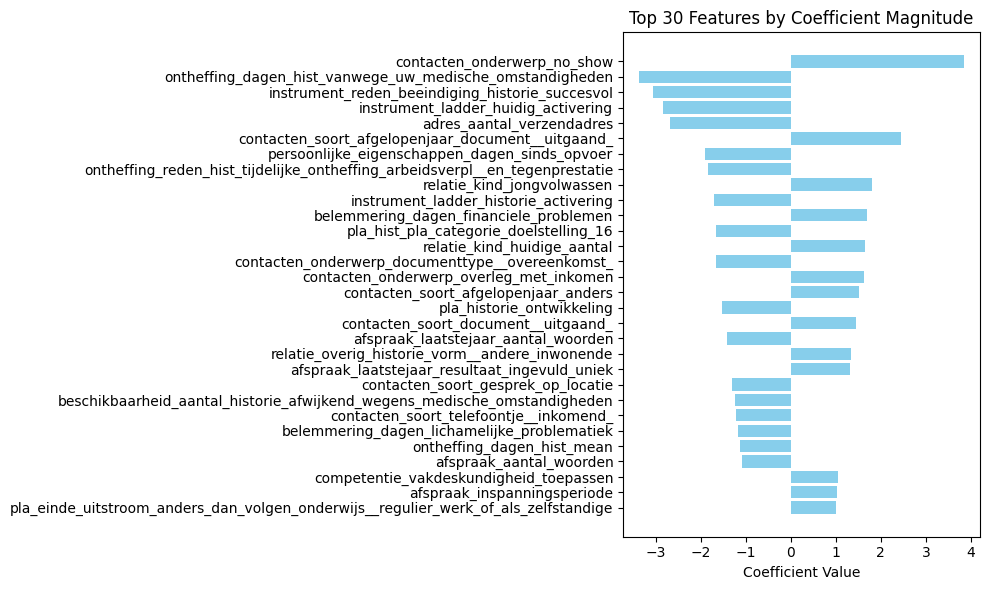

In [ ]:
# Extract feature coefficients
trained_model = pipeline.named_steps['regression']
coefficients = trained_model.coef_[0]
feature_names = X_train.columns
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Absolute Coefficient': np.abs(coefficients)
}).sort_values(by='Absolute Coefficient', ascending=False)

# Display top 30 features
top_n = 30
print(f"Top {top_n} features by coefficient:")
print(feature_importance[['Feature', 'Coefficient']].head(top_n))

# Visualize top features
plot_top_features(feature_importance, top_n=top_n)